##### Imports

In [1]:
"""
Focus on human data primarily on hIVSCC-MET for AIBS
-Tree call for Mouse
-Seurat prediction score for Human

*Make a scatter plot NMS score vs Seurat prediction score (Add n values) --DONE
1) RNA amp pass --DONE
2) RNA amp fail --DONE
*Make same plot as Agata with barplot -- DONE

Collaborators have hIVSCC-MET and hIVSCC-METx


*Look at the RNA Fail/NMS pass data core vs the rest to see what separates them
"""

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "rna_plot/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Filtering shiny dataframe

In [4]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

In [5]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)
shiny_human.dropna(subset=["cell_specimen_project"],inplace=True) #3578 rows

INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [6]:
shinyh = filter_df(shiny_human, "cell_specimen_project", "hIVSCC-MET") #1566
shinyh = create_container_df(shinyh, "sample_id")
shinyh.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True) #1551

collaborator_dict = {"PG" : "Gabor", "PH" : "Mansvelder"}
for collab in ["P1", "P2", "P6", "P7", "P8", "P9", "PA", "PB", "PE", "PF", "PX", "P3", "P0", "P5"]:
    collaborator_dict[collab] = "AIBS"

shinyh["collaborator_label"] = shinyh["collaborator_label"].replace(collaborator_dict)
shinyh = filter_df(shinyh, "collaborator_label", "AIBS") #1489
shinyh.drop(columns=["cell_name", "cell_specimen_project"], inplace=True)
shinyh["NMS Pass/Fail"] = shinyh["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"}) #Changing to keep same format

INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == hIVSCC-MET
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["collaborator_label"] = df[container_col].str[0:2]
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:

##### Creating count_rn for countplot

In [7]:
shinyh_npass = filter_df(shinyh, "NMS Pass/Fail", "Pass")
shinyh_nfail = filter_df(shinyh, "NMS Pass/Fail", "Fail")
shinyh_rpass = filter_df(shinyh, "RNA Pass/Fail", "Pass")
shinyh_rfail = filter_df(shinyh, "RNA Pass/Fail", "Fail")

INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on RNA Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on RNA Pass/Fail == Fail


In [8]:
rfail_nfail = filter_df(shinyh_rfail, "NMS Pass/Fail", "Fail")
rfail_npass = filter_df(shinyh_rfail, "NMS Pass/Fail", "Pass")
rpass_nfail = filter_df(shinyh_rpass, "NMS Pass/Fail", "Fail")
rpass_npass = filter_df(shinyh_rpass, "NMS Pass/Fail", "Pass")

INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass


In [9]:
rfail_nfail["Group"] = "RNA Fail/NMS Fail"
rfail_npass["Group"] = "RNA Fail/NMS Pass"
rpass_nfail["Group"] = "RNA Pass/NMS Fail"
rpass_npass["Group"] = "RNA Pass/NMS Pass"

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [10]:
count_rn = pd.concat([rfail_nfail, rfail_npass, rpass_nfail, rpass_npass])

count_rn.drop(columns=["sample_id", "cDNA quality (%>400 bp)", "RNA Pass/Fail",
                       "Amplified content (ng)", "NMS score", "NMS Pass/Fail", "Seurat prediction score",
                       "collaborator_label"], inplace=True)

count_rn["Group_count"] = count_rn.groupby(["Group", "Tree_call"])["Tree_call"].transform("count")
count_rn["Group_total"] = count_rn.groupby("Group")["Tree_call"].transform("count")
count_rn["proportion"] = count_rn["Group_count"] / count_rn["Group_total"]

new_piv = pd.pivot_table(count_rn, values='proportion', index=["Group"], columns="Tree_call", fill_value=0)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [11]:
new_piv

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Fail/NMS Fail,0.000000,0.000000,0.000000,0.000000,1.000000
RNA Fail/NMS Pass,0.144928,0.043478,0.086957,0.028986,0.695652
RNA Pass/NMS Fail,0.005952,0.000000,0.005952,0.000000,0.988095
RNA Pass/NMS Pass,0.498145,0.237477,0.172542,0.007421,0.084416


##### Plot Colors

In [12]:
pf_colors={"Pass": "#41ab5d", "Fail": "#ef3b2c"}
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

##### FacetGrid Plots

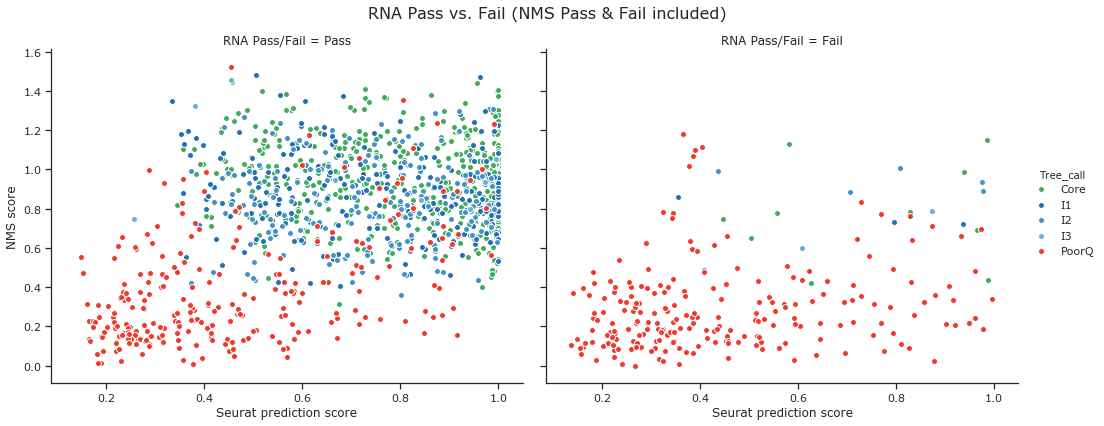

In [13]:
g = sns.FacetGrid(data=shinyh, col="RNA Pass/Fail", height=6, aspect=1.2,
                  hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
g = g.map(plt.scatter, "Seurat prediction score", "NMS score", edgecolor="w") \
         .add_legend() \
         .fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.88)
plt.suptitle("RNA Pass vs. Fail (NMS Pass & Fail included)", size=16)
plt.savefig(plot_path + "facplot_rna_pass_fail_all_nms.jpeg", bbox_inches="tight")

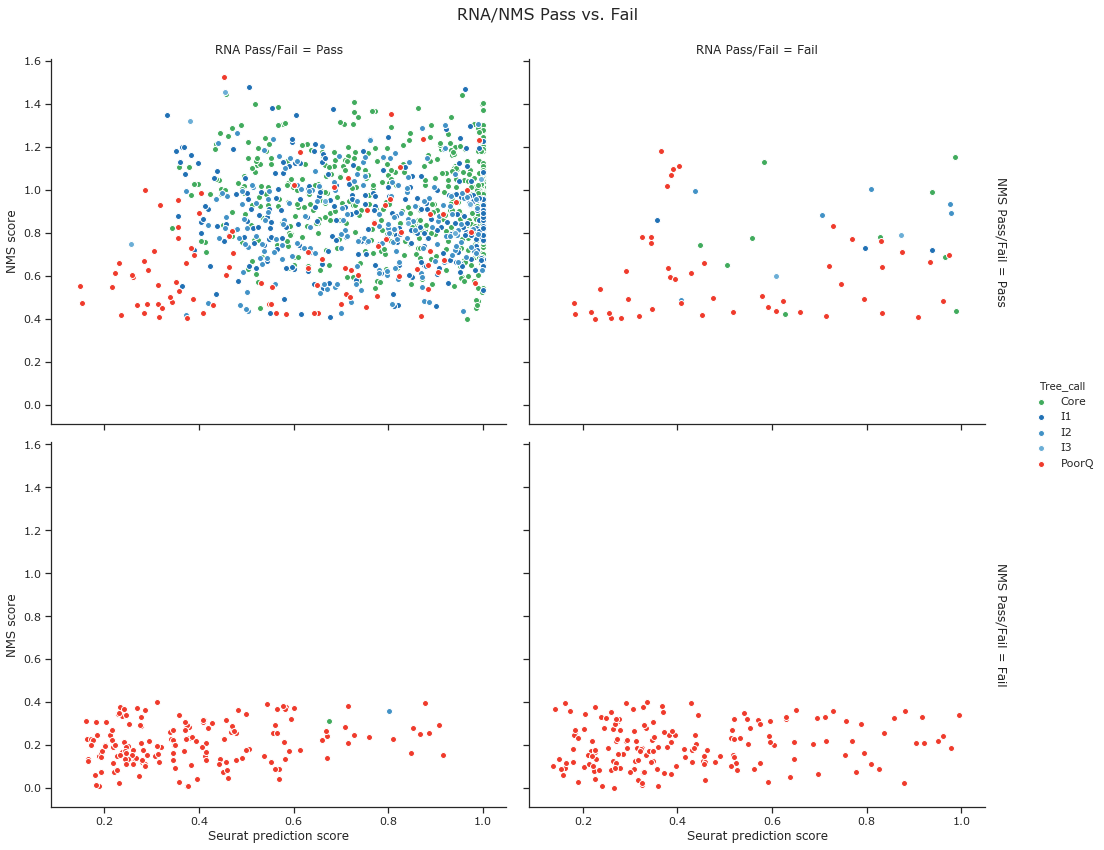

In [14]:
g = sns.FacetGrid(data=shinyh, col="RNA Pass/Fail", row="NMS Pass/Fail", height=6, aspect=1.2,
                  hue="Tree_call", hue_order=tree_colors, palette=tree_colors, margin_titles=True)
g = g.map(plt.scatter, "Seurat prediction score", "NMS score", edgecolor="w") \
         .add_legend() \
         .fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.92)
plt.suptitle("RNA/NMS Pass vs. Fail", size=16)
plt.savefig(plot_path + "facplot_rna_nms_all.jpeg", bbox_inches="tight")

##### JointPlots

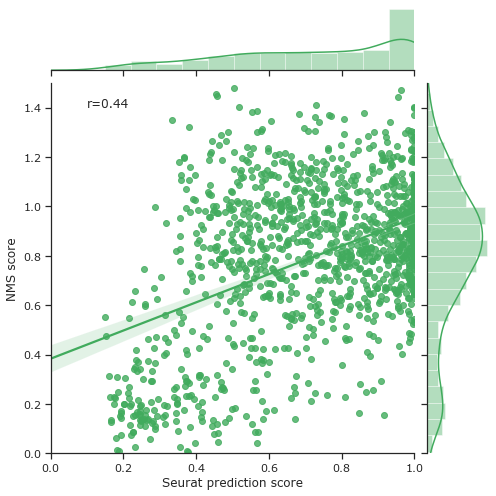

In [15]:
corr = pearsonr(shinyh_rpass["Seurat prediction score"], shinyh_rpass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"
ax = sns.jointplot(x="Seurat prediction score", y="NMS score", data=shinyh_rpass, kind="reg", color="#41ab5d", height=7)

plt.text(0.1, 1.4, text, fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.savefig(plot_path + "jointplot_rna_pass.jpeg", bbox_inches="tight")

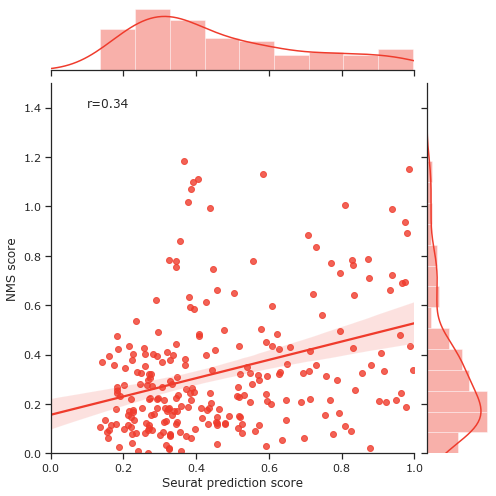

In [16]:
corr = pearsonr(shinyh_rfail["Seurat prediction score"], shinyh_rfail["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"
ax = sns.jointplot(y="NMS score", x="Seurat prediction score", data=shinyh_rfail, kind="reg", color="#ef3b2c", height=7)

plt.text(0.1, 1.4, text, fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.savefig(plot_path + "jointplot_rna_fail.jpeg", bbox_inches="tight")

##### ScatterPlots

Core : 538
I1 : 256
I2 : 187
I3 : 8
PoorQ : 257


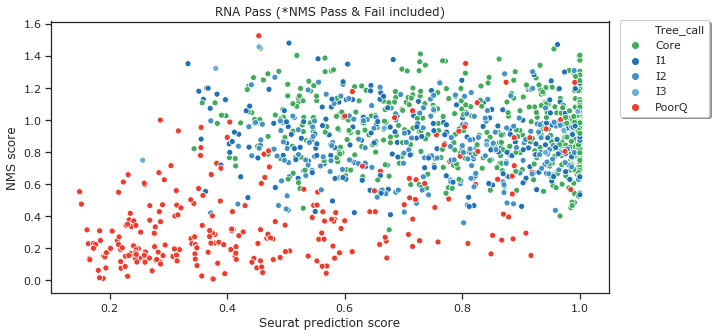

In [17]:
fig_dims = (10, 5)
f, axes = plt.subplots(figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=shinyh_rpass, 
                hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
ax.set_title("RNA Pass (*NMS Pass & Fail included)")
plt.legend(bbox_to_anchor=(1.01, 1.025), loc=2, fancybox=True, shadow=True)

tree_list = {"Core": 538, "I1": 256, "I2": 187, "I3": 8, "PoorQ": 257}
l = [print(key, ":", value) for key, value in tree_list.items()]
plt.savefig(plot_path + "scaplot_rna_pass_all_nms.jpeg", bbox_inches="tight")

Core : 537
I1 : 256
I2 : 186
I3 : 8
PoorQ : 91


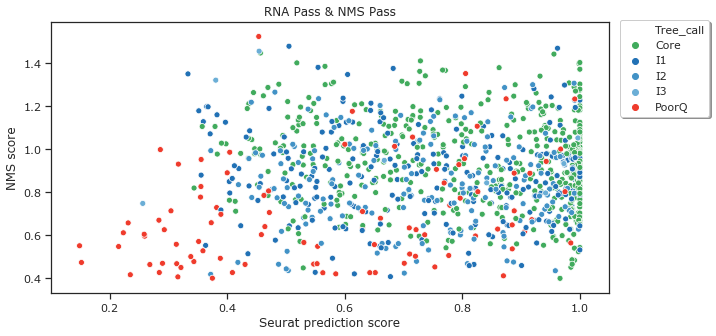

In [18]:
fig_dims = (10, 5)
f, axes = plt.subplots(figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=rpass_npass, 
                hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
ax.set_title("RNA Pass & NMS Pass")
plt.legend(bbox_to_anchor=(1.01, 1.025), loc=2, fancybox=True, shadow=True)

tree_list = {"Core": 537, "I1": 256, "I2": 186, "I3": 8, "PoorQ": 91}
l = [print(key, ":", value) for key, value in tree_list.items()]
plt.savefig(plot_path + "scaplot_rna_pass_nms_pass.jpeg", bbox_inches="tight")

Core : 10
I1 : 3
I2 : 6
I3 : 2
PoorQ : 222


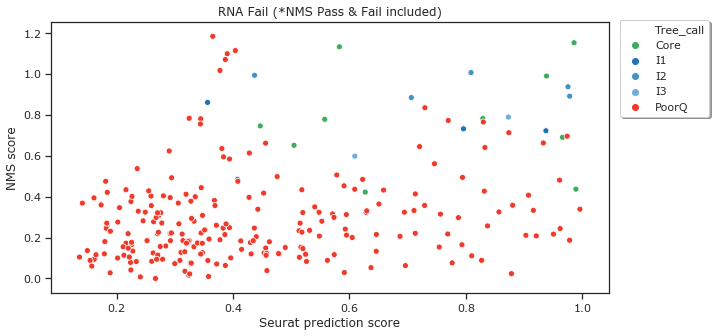

In [19]:
fig_dims = (10, 5)
f, axes = plt.subplots(figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=shinyh_rfail, 
                hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
ax.set_title("RNA Fail (*NMS Pass & Fail included)")
plt.legend(bbox_to_anchor=(1.01, 1.025), loc=2, fancybox=True, shadow=True)

tree_list = {"Core": 10, "I1": 3, "I2": 6, "I3": 2, "PoorQ": 222}
l = [print(key, ":", value) for key, value in tree_list.items()]
plt.savefig(plot_path + "scaplot_rna_fail_all_nms.jpeg", bbox_inches="tight")

Core : 10
I1 : 3
I2 : 6
I3 : 2
PoorQ : 48


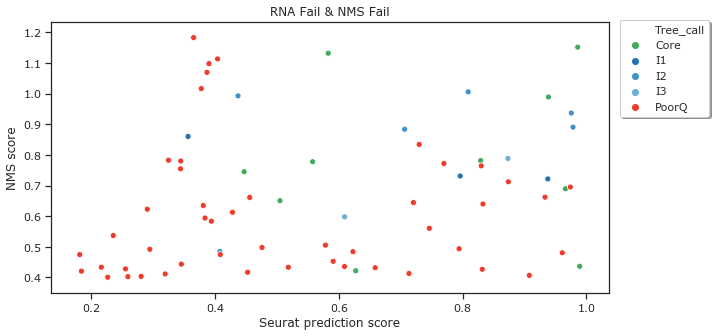

In [20]:
fig_dims = (10, 5)
f, axes = plt.subplots(figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=rfail_npass, 
                hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
ax.set_title("RNA Fail & NMS Fail")
plt.legend(bbox_to_anchor=(1.01, 1.025), loc=2, fancybox=True, shadow=True)

tree_list = {"Core": 10, "I1": 3, "I2": 6, "I3": 2, "PoorQ": 48}
l = [print(key, ":", value) for key, value in tree_list.items()]
plt.savefig(plot_path + "scaplot_rna_fail_nms_pass.jpeg", bbox_inches="tight")

##### RegPlots

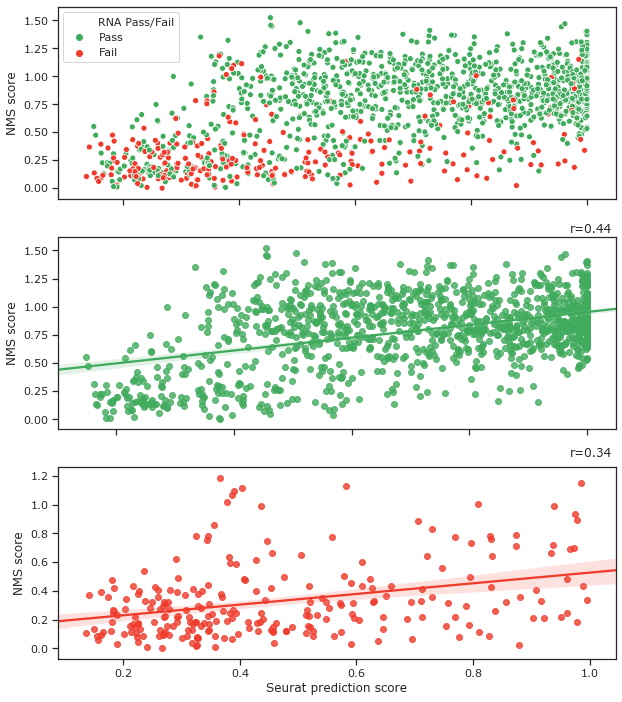

In [21]:
fig_dims = (10, 12)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=shinyh,
                     palette=pf_colors, hue="RNA Pass/Fail", ax=axes[0])

corr = pearsonr(shinyh_rpass["Seurat prediction score"], shinyh_rpass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax1 = sns.regplot(y="NMS score", x="Seurat prediction score", data=shinyh_rpass, color="#41ab5d", ax=axes[1])
ax.text(0.97, -0.4, text, fontsize=12)


corr = pearsonr(shinyh_rfail["Seurat prediction score"], shinyh_rfail["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax2 = sns.regplot(y="NMS score", x="Seurat prediction score", data=shinyh_rfail, color="#ef3b2c", ax=axes[2])
ax.text(0.97, -2.4, text, fontsize=12)


ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax.set_xlabel("")
ax1.set_xlabel("")
plt.savefig(plot_path + "regplot_rna_pass_vs_fail_all_nms.jpeg", bbox_inches="tight")

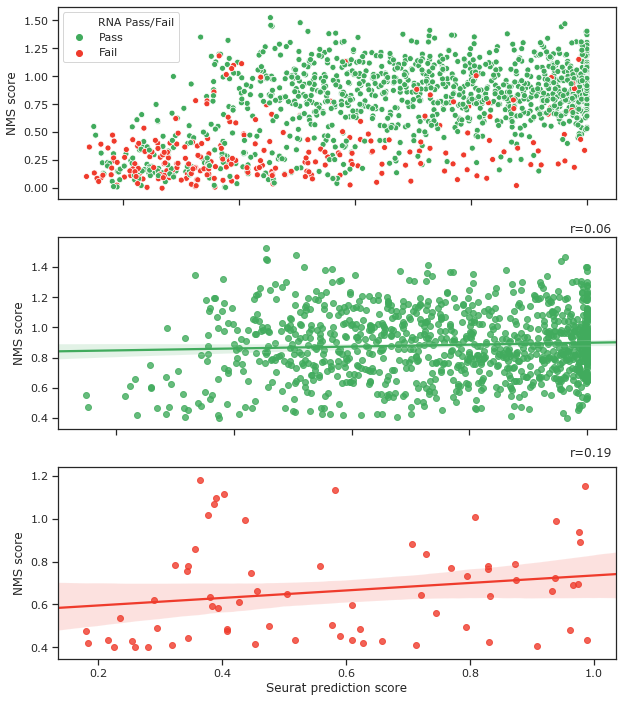

In [22]:
fig_dims = (10, 12)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="Seurat prediction score", data=shinyh,
                     palette=pf_colors, hue="RNA Pass/Fail", ax=axes[0])

corr = pearsonr(rpass_npass["Seurat prediction score"], rpass_npass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax1 = sns.regplot(y="NMS score", x="Seurat prediction score", data=rpass_npass, color="#41ab5d", ax=axes[1])
ax.text(0.97, -0.4, text, fontsize=12)


corr = pearsonr(rfail_npass["Seurat prediction score"], rfail_npass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax2 = sns.regplot(y="NMS score", x="Seurat prediction score", data=rfail_npass, color="#ef3b2c", ax=axes[2])
ax.text(0.97, -2.4, text, fontsize=12)


ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax.set_xlabel("")
ax1.set_xlabel("")
plt.savefig(plot_path + "regplot_rna_pass_vs_fail_nms_pass.jpeg", bbox_inches="tight")

##### Countplot

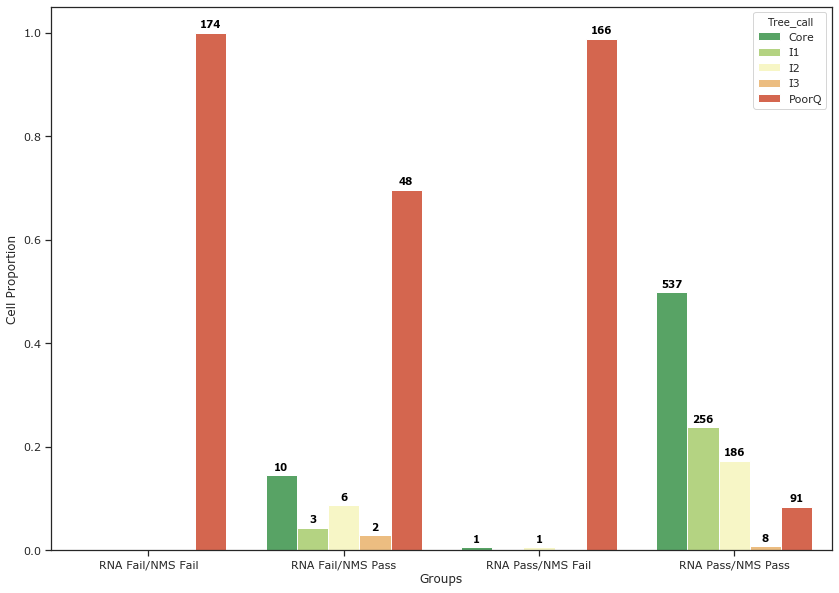

In [23]:
fig_dims = (14, 10)
f, axes = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Group", y="proportion", hue="Tree_call", data=count_rn, hue_order=tree_colors, palette="RdYlGn_r")
ax.set(xlabel="Groups", ylabel="Cell Proportion")

core = [0, 10, 1, 537]
i1 = [0, 3, 0, 256]
i2 = [0, 6, 1, 186]
i3 = [0, 2, 0, 8]
poorq = [174, 48, 166, 91]
count_list = core + i1 + i2 + i3 + poorq

i=0
for p in ax.patches:
    top_rect = p.get_height() + 0.01
    mid_rect = p.get_x() + p.get_width()/2
    label_rect = count_list[i]
    ax.text(mid_rect, top_rect, label_rect,
            ha="center", size="medium", color='black', weight='bold')
    i += 1

plt.savefig(plot_path + "countplot_rna_groups.jpeg", bbox_inches="tight")

In [24]:
count_rn

,Tree_call,Group,Group_count,Group_total,proportion
878,PoorQ,RNA Fail/NMS Fail,174,174,1.000000
1216,PoorQ,RNA Fail/NMS Fail,174,174,1.000000
1597,PoorQ,RNA Fail/NMS Fail,174,174,1.000000
2068,PoorQ,RNA Fail/NMS Fail,174,174,1.000000
2175,PoorQ,RNA Fail/NMS Fail,174,174,1.000000
...,...,...,...,...,...
2938,PoorQ,RNA Pass/NMS Pass,91,1078,0.084416
2988,PoorQ,RNA Pass/NMS Pass,91,1078,0.084416
3020,PoorQ,RNA Pass/NMS Pass,91,1078,0.084416
3124,PoorQ,RNA Pass/NMS Pass,91,1078,0.084416


##### Stacked BarPlot

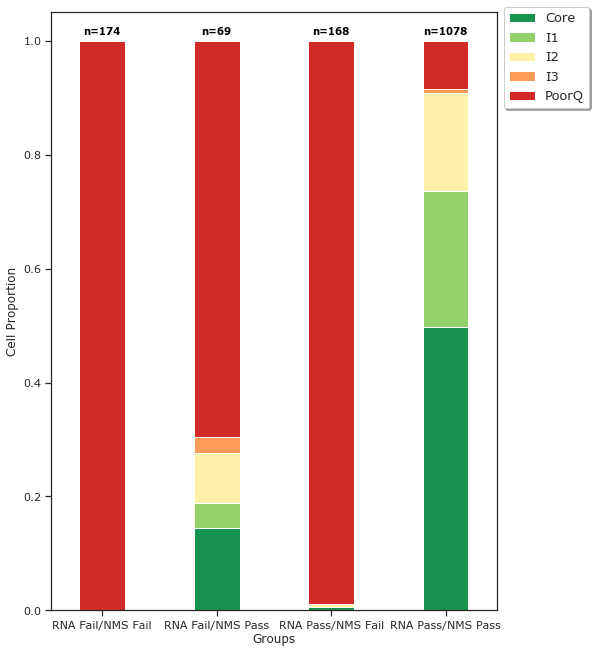

In [25]:
def stacked_plot(df):
    groups_order = ["RNA Fail/NMS Fail", "RNA Fail/NMS Pass", "RNA Pass/NMS Fail", "RNA Pass/NMS Pass"]
    tree_order = ["Core", "I1", "I2", "I3", "PoorQ"]
    ax = df.loc[groups_order].plot(kind="bar", stacked = True, figsize= (8,11), rot = 0,
                                   colormap=ListedColormap(sns.color_palette("RdYlGn_r", 10)),width = 0.4)

    ax.legend(tree_order, loc = 0, bbox_to_anchor = (1, 1.02), frameon = True, shadow = True, fontsize = 13)
    ax.set(xlabel = "Groups", ylabel = "Cell Proportion")
    
    i=0
    count_list = ["n=174", "n=69", "n=168", "n=1078"]
    
    rects = ax.patches
    labels = count_rn.Group_total.value_counts()
    
    for p, label in zip (rects, labels):
        top_rect = 1 + 0.01
        mid_rect = p.get_x() + p.get_width()/2
        label_rect = count_list[i]
        ax.text(x=mid_rect, y=top_rect, s=label_rect,
                ha="center", size="medium", color="black", weight="bold")
        i += 1
    plt.savefig(plot_path + "stackplot_rna_groups.jpeg", bbox_inches="tight")
        
stacked_plot(new_piv)

##### Info

In [26]:
print(f"RNA Fail/NMS Fail: {rfail_nfail.sample_id.count()}")
print(f"RNA Fail/NMS Pass: {rfail_npass.sample_id.count()}")
print(f"RNA Pass/NMS Fail: {rpass_nfail.sample_id.count()}")
print(f"RNA Pass/NMS Pass: {rpass_npass.sample_id.count()}")

RNA Fail/NMS Fail: 174
RNA Fail/NMS Pass: 69
RNA Pass/NMS Fail: 168
RNA Pass/NMS Pass: 1078


In [27]:
print(f"Rpass total count: {shinyh_rpass.sample_id.count()}")
print(f"Rfail total count: {shinyh_rfail.sample_id.count()}")

Rpass total count: 1246
Rfail total count: 243


In [28]:
rfail_nfail.Tree_call.value_counts(normalize=True) #rfail_nfail["Tree_call"].value_counts() / rfail_nfail["Tree_call"].count()
rfail_npass.Tree_call.value_counts(normalize=True)
rpass_nfail.Tree_call.value_counts(normalize=True)
rpass_npass.Tree_call.value_counts(normalize=True)

Core     0.498145
I1       0.237477
I2       0.172542
PoorQ    0.084416
I3       0.007421
Name: Tree_call, dtype: float64

In [29]:
count_rn["Group"].value_counts() / count_rn["Group"].count()

RNA Pass/NMS Pass    0.723976
RNA Fail/NMS Fail    0.116857
RNA Pass/NMS Fail    0.112827
RNA Fail/NMS Pass    0.046340
Name: Group, dtype: float64

##### Counts

In [30]:
aibs = filter_df(shinyh, "collaborator_label", "AIBS")
pg = filter_df(shinyh, "collaborator_label", "Gabor")
ph = filter_df(shinyh, "collaborator_label", "Mansvelder")
print(f"Human total count: {shinyh.sample_id.count()}")
print(f"AIBS count: {aibs.sample_id.count()}")
print(f"Gabor count: {pg.sample_id.count()}")
print(f"Mansvelder count: {ph.sample_id.count()}")

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Gabor
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Mansvelder


Human total count: 1489
AIBS count: 1489
Gabor count: 0
Mansvelder count: 0
